# Table of Contents
- [Data preparation](#prep)
    - [Read in data files](#read)
    - [Merge datasets together](#merge)
    - [Normalize values by durations and ratios](#norm)
    - [Visualize distributions and remove outliers](#outliers)
    - [Center values at 0 and scale them between -1 and 1](#scale)
    - [Sanity check](#check)
- [Data exploration](#explo)
    - [Correlation heatmaps](#heatmap)
    - [Correlation to winning](#corr_win)
- [Modelling](#model)
    - [Train/test split](#split)
    - [Parameter choices](#parameters)
    - [Lasso regression](#lasso)
    - [Decision tree](#tree)
    - [Multi-layer perceptron](#mlp)
    - [Results](#results)
- [Model analysis](#analysis)
    - [Parameter tuning sensitivity](#sensitivity)
    - [Feature importance](#importance)
    - [Feature ablation](#ablation)
    - [Checking incorrect predictions](#check_incorrect)

The following sections are adapted from our milestone 1 project:

- Most of data preparation (except for the appending of the unsupervised hero/text data)
- The first two correlation heatmaps in data exploration

We use pep8 for code formatting for the most part, but chose to have slightly longer code line lengths (length 100 instead of 80).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle
import warnings

<a id="prep"></a>
# Data preparation

**The majority of this section is adapted from our milestone 1 code.** We made adjustments based on instructor feedback, as well as the context of the new project.

Data preparation steps are as follows:

1. Read in the data files downloaded from Kaggle, reduce them to features we're interested in, and re-shape them to be easily merged. 
2. Merge the data together.
3. Append the fields generated from other parts of this project (unsupervised hero/text data).
4. Normalize the values by duration. This is important so that longer matches aren't heavily favoured.
5. Manually inspect distributions of each feature to check for and remove outliers. (Some of these features are diverse enough for us to be uncomfortable doing so programmatically - we may be introducing biases.)
6. Center values at 0, and scale them between -1 and 1 i,n preparation for machine learning algorithms (so that features with heavy skews and/or an inherently larger magnitude don't skew the algorithm as much).
7. Do a sanity check on the data with descriptive statistics.

<a id="read"></a>
## Read in data files

In [2]:
match_raw = pd.read_csv("../data/dota/match.csv")
objectives_raw = pd.read_csv("../data/dota/objectives.csv")
hero_names_raw = pd.read_csv("../data/dota/hero_names.csv")

players_chat = pd.read_csv("../intermediate/players_chat.csv")

### match.csv

This file describes individual matches.

In [3]:
# Filter to ranked 5v5 with durations (i.e. matches that actually started)
match_clean = match_raw[
    (match_raw["game_mode"] == 22) & match_raw["duration"].notnull()
].reset_index(drop=True)


# Convert tower and barracks statuses to counts of # towers/barracks destroyed
# See https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status for details on formatting
def count_bin1(x):  # Helper function to count number of 1s in binary string
    return "{0:b}".format(x).count("1")


match_clean["turret_count1"] = match_clean["tower_status_radiant"].apply(count_bin1)
match_clean["turret_count2"] = match_clean["tower_status_dire"].apply(count_bin1)
match_clean["inhib_count1"] = match_clean["barracks_status_radiant"].apply(count_bin1)
match_clean["inhib_count2"] = match_clean["barracks_status_dire"].apply(count_bin1)
match_clean["winner"] = np.where(match_clean["radiant_win"], "blue", "red")

# Select needed columns only
matches_wide = match_clean[
    [
        "match_id",
        "duration",
        "turret_count1",
        "turret_count2",
        "inhib_count1",
        "inhib_count2",
        "winner",
    ]
].reset_index(drop=True)
matches = pd.wide_to_long(
    matches_wide, ["turret_count", "inhib_count"], i="match_id", j="team"
).reset_index()
matches["team"] = np.where(matches["team"] == 1, "blue", "red")
matches.head()

,match_id,team,duration,winner,turret_count,inhib_count
0,0,blue,2375,blue,9,6
1,1,blue,2582,red,0,0
2,2,blue,2716,red,1,2
3,3,blue,3085,red,1,2
4,4,blue,1887,blue,11,6


### objectives.csv

This file describes objectives that were obtained during a match.

Although objectives.csv contains many different objectives, we don't need all of them because some of them are already represented in match.csv.

Of the remaining objectives, all of them are represented in different formats, so we have to adjust their information to a consistent format on a case-by-case basis.

In [4]:
# Some objectives are covered in match.csv
req_objectives = [
    "CHAT_MESSAGE_AEGIS",
    "CHAT_MESSAGE_AEGIS_STOLEN",
    "CHAT_MESSAGE_ROSHAN_KILL",
    "CHAT_MESSAGE_FIRSTBLOOD",
]
objectives_long = objectives_raw[
    objectives_raw["subtype"].isin(req_objectives)
].reset_index(drop=True)
objectives_long["subtype"] = (
    objectives_long["subtype"].str.replace("CHAT_MESSAGE_", "").str.lower()
)
# Merge aegis and aegis stolen (we don't care about whether it was stolen)
objectives_long["subtype"] = np.where(
    objectives_long["subtype"] == "aegis_stolen", "aegis", objectives_long["subtype"]
)
# Get which team obtained objectives - table is messy and each subtype uses different information to denote team
objectives_long["team"] = np.where(
    objectives_long["subtype"] == "roshan_kill",  # This subtype includes team data
    np.where(objectives_long["team"] == 2, "blue", "red"),
    np.where(objectives_long["player1"] <= 4, "blue", "red"),
)  # Otherwise, use player ID
# Create column for whether each objective was obtained
objective_cols = ["aegis", "roshan_kill", "firstblood"]
for i in objective_cols:
    objectives_long[i] = np.where(objectives_long["subtype"] == i, 1, 0)

In [5]:
# Get number of objectives completed by team per match
objectives_long["team"] = pd.Categorical(objectives_long["team"])
objectives = objectives_long.groupby(["match_id", "team"]).agg("sum").reset_index()
objectives = objectives[["match_id", "team"] + objective_cols]
objectives.head()

,match_id,team,aegis,roshan_kill,firstblood
0,0,blue,2,2,1
1,0,red,0,0,0
2,1,blue,1,1,1
3,1,red,1,1,0
4,2,blue,0,0,0


### players_chat.csv

This file describes player statistics per match, with some extra metrics from our chat sentiment analysis appended.

In [6]:
# Select needed columns
# We don't use all available columns because
# a) some of them are too granular to be reasonable for our sample size
# (spurious patterns become likely), and
# b) some of them are not objectives that players can meaningfully work toward
players = players_chat[
    [
        "match_id",
        "player_slot",
        "hero_id",
        "gold",
        "gold_spent",
        "xp_per_min",
        "kills",
        "deaths",
        "assists",
        "denies",
        "last_hits",
        "hero_damage",
        "hero_healing",
        "tower_damage",
        "level",
        "polarity_tb",
        "polarity_sia",
        "word_count",
        "avg_word_length",
    ]
].reset_index(drop=True)
players = players.rename(columns={"xp_per_min": "xp"})
# Get teams of players
players["team"] = np.where(players["player_slot"] >= 5, "red", "blue")
players.head()

,match_id,player_slot,hero_id,gold,gold_spent,xp,kills,deaths,assists,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,team
0,16255,130.0,4.0,2026.0,14765.0,519.0,10.0,14.0,12.0,3.0,106.0,15713.0,1178.0,331.0,21.0,0.010000,-0.06944,2.0,3.633333,red
1,20158,4.0,11.0,1.0,12330.0,438.0,8.0,7.0,2.0,14.0,197.0,11676.0,0.0,489.0,17.0,0.000000,0.00000,1.0,1.000000,blue
2,21463,4.0,36.0,1201.0,17020.0,510.0,15.0,8.0,15.0,11.0,120.0,15468.0,2202.0,1879.0,18.0,0.066667,0.25160,2.0,3.583333,blue
3,45976,132.0,7.0,3575.0,7860.0,480.0,6.0,4.0,17.0,0.0,35.0,12313.0,0.0,753.0,16.0,0.000000,0.00000,0.0,0.000000,red
4,37915,130.0,86.0,3420.0,12900.0,387.0,4.0,9.0,21.0,3.0,70.0,9443.0,578.0,846.0,18.0,0.000000,0.00000,1.0,2.000000,red


<a id="merge"></a>
## Merge datasets together

In [7]:
dota_overall = matches.merge(objectives, how="outer", on=["match_id", "team"]).merge(
    players, how="outer", on=["match_id", "team"]
)
# Rearrange columns
desc_cols = ["match_id", "team", "player_slot", "hero_id", "duration", "winner"]
dota_overall = dota_overall[
    desc_cols + [x for x in dota_overall.columns if x not in desc_cols]
]
dota_overall["winner"] = dota_overall["winner"] == dota_overall["team"]
# Filter out games without hero ID (seems to be a data glitch)
dota_overall = dota_overall[~dota_overall["hero_id"].isna()].reset_index(drop=True)
dota_overall.head()

,match_id,team,player_slot,hero_id,duration,winner,turret_count,inhib_count,aegis,roshan_kill,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
0,312,blue,2.0,14.0,2760.0,True,7.0,6.0,1.0,1.0,...,3.0,102.0,15717.0,0.0,310.0,21.0,-0.145833,-0.057963,3.125000,3.868750
1,2475,blue,1.0,101.0,2725.0,True,5.0,6.0,3.0,3.0,...,4.0,35.0,13588.0,0.0,1019.0,17.0,0.533333,0.331133,1.333333,3.500000
2,2676,blue,0.0,32.0,3743.0,False,1.0,3.0,2.0,2.0,...,2.0,86.0,7403.0,0.0,484.0,21.0,0.000000,0.000000,0.000000,0.000000
3,2753,blue,3.0,32.0,2440.0,True,8.0,6.0,0.0,0.0,...,0.0,61.0,11696.0,0.0,762.0,18.0,-0.111905,-0.126350,5.000000,5.916667
4,4527,blue,0.0,62.0,2133.0,False,1.0,2.0,0.0,0.0,...,1.0,32.0,7912.0,0.0,0.0,14.0,0.000000,0.000000,3.500000,2.250000


<a id="norm"></a>
## Normalize values by duration

In [8]:
dota_per_min = dota_overall.copy()
metric_cols = list(dota_per_min.columns[6:])
# Get per-min values for time-dependent metrics
for field in metric_cols:
    if field not in [
        "xp",
        "polarity_tb",
        "polarity_sia",
        "chat",
        "word_count",
        "avg_word_length",
    ]:
        dota_per_min[field] = dota_per_min[field] * 60 / dota_per_min["duration"]
dota_per_min = dota_per_min.reset_index(drop=True)
dota_per_min.head()

,match_id,team,player_slot,hero_id,duration,winner,turret_count,inhib_count,aegis,roshan_kill,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
0,312,blue,2.0,14.0,2760.0,True,0.152174,0.130435,0.021739,0.021739,...,0.065217,2.217391,341.673913,0.0,6.739130,0.456522,-0.145833,-0.057963,3.125000,3.868750
1,2475,blue,1.0,101.0,2725.0,True,0.110092,0.132110,0.066055,0.066055,...,0.088073,0.770642,299.185321,0.0,22.436697,0.374312,0.533333,0.331133,1.333333,3.500000
2,2676,blue,0.0,32.0,3743.0,False,0.016030,0.048090,0.032060,0.032060,...,0.032060,1.378573,118.669516,0.0,7.758483,0.336628,0.000000,0.000000,0.000000,0.000000
3,2753,blue,3.0,32.0,2440.0,True,0.196721,0.147541,0.000000,0.000000,...,0.000000,1.500000,287.606557,0.0,18.737705,0.442623,-0.111905,-0.126350,5.000000,5.916667
4,4527,blue,0.0,62.0,2133.0,False,0.028129,0.056259,0.000000,0.000000,...,0.028129,0.900141,222.559775,0.0,0.000000,0.393812,0.000000,0.000000,3.500000,2.250000


<a id="outliers"></a>
## Visualize distributions and remove outliers

We plot and then manually inspect the distributions:

turret_count


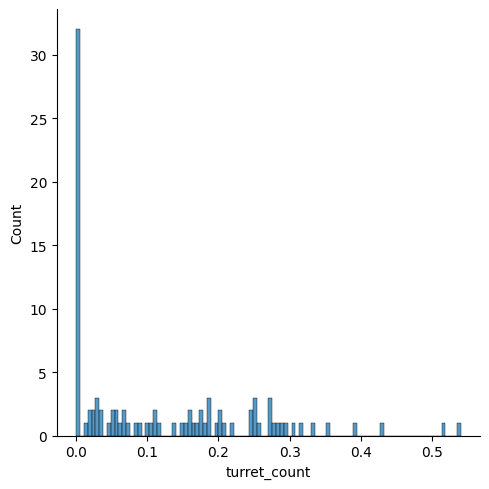

inhib_count


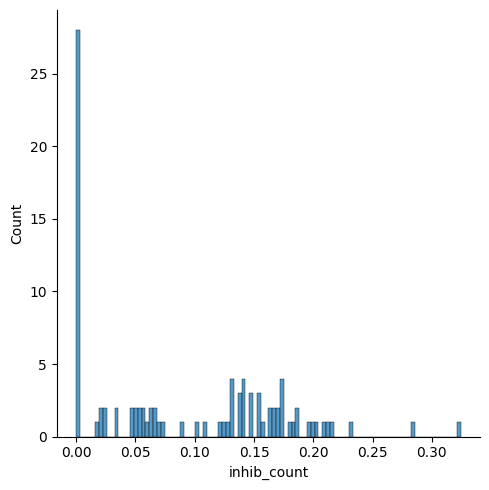

aegis


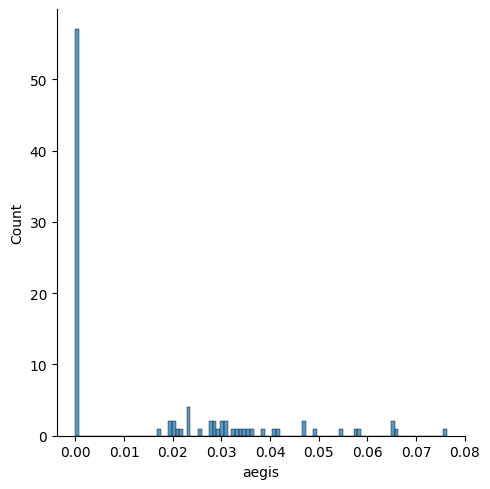

roshan_kill


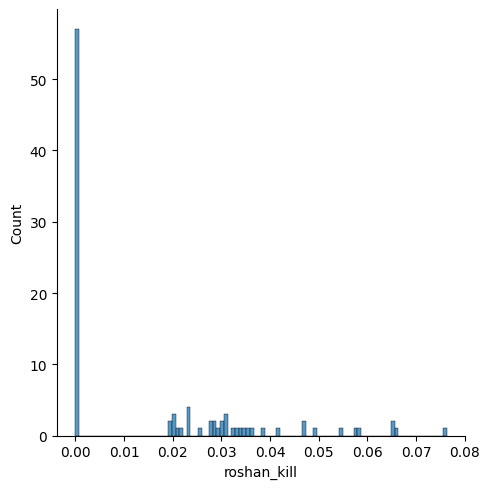

firstblood


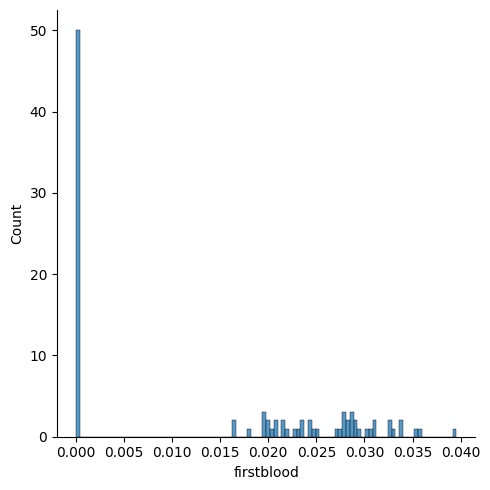

gold


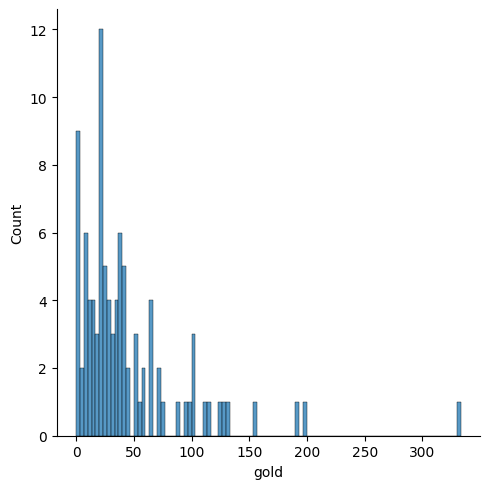

gold_spent


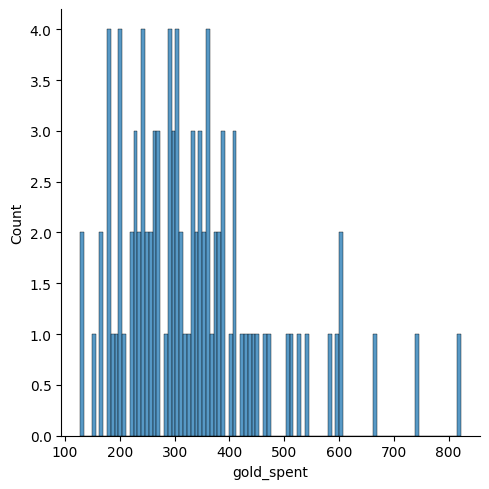

xp


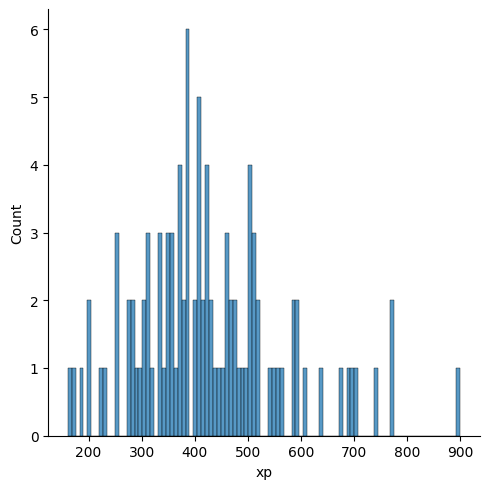

kills


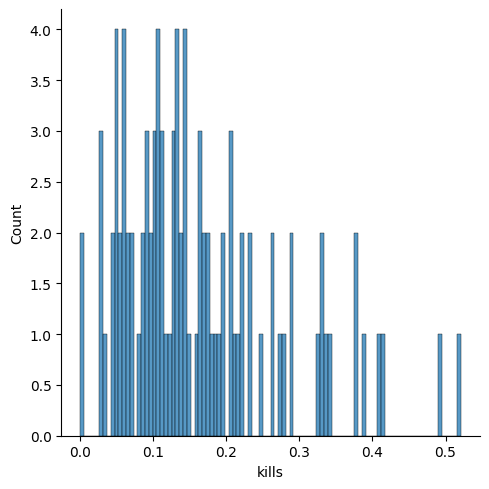

deaths


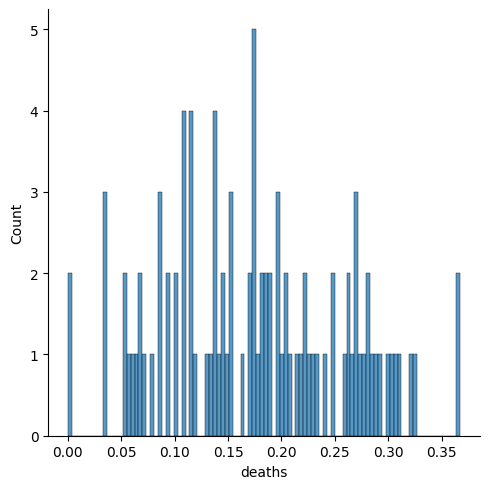

assists


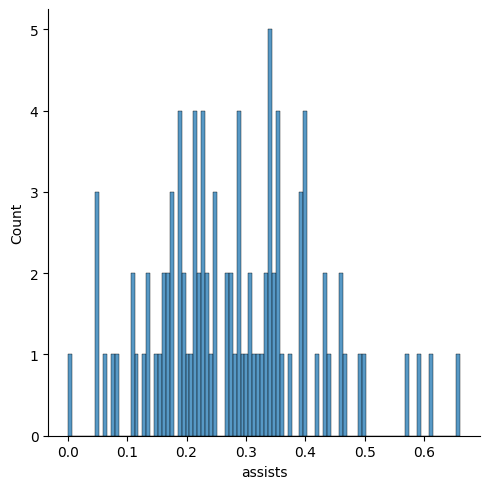

denies


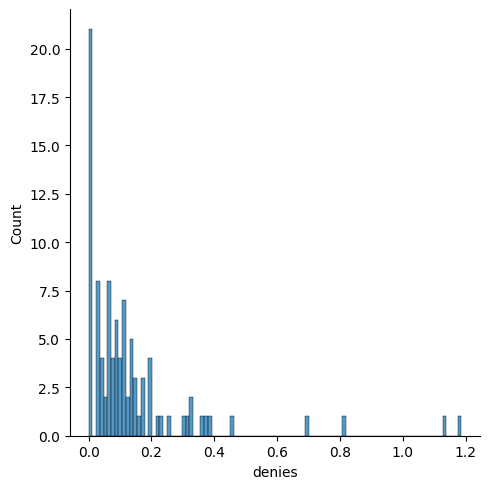

last_hits


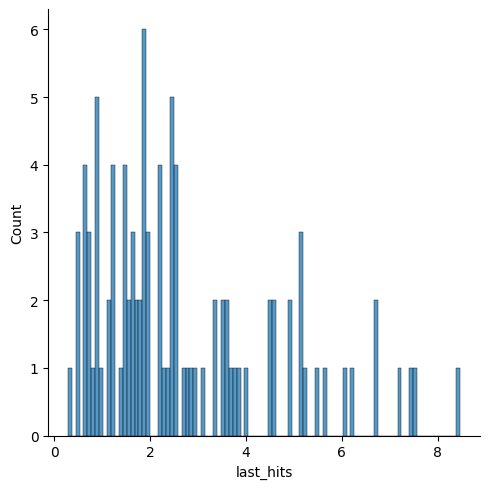

hero_damage


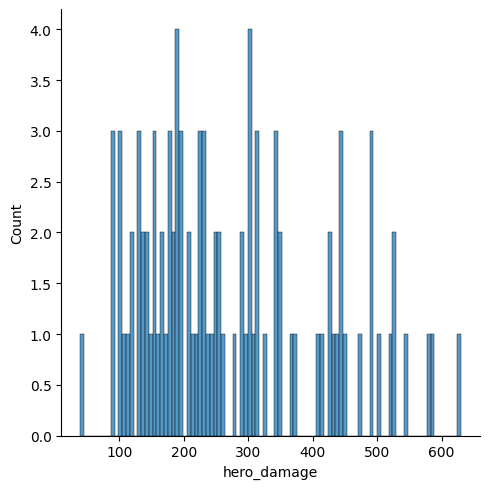

hero_healing


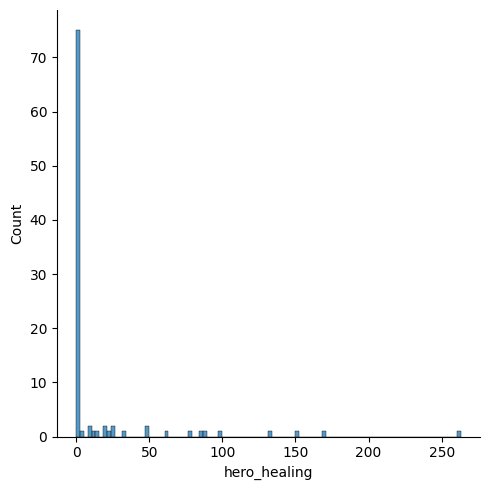

tower_damage


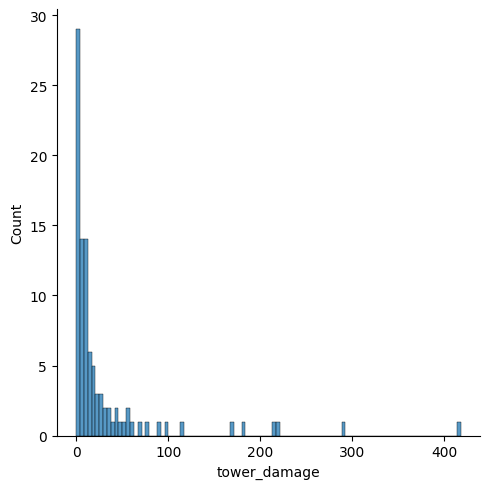

level


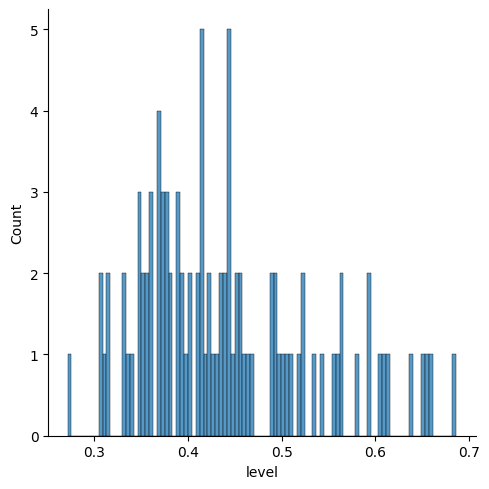

polarity_tb


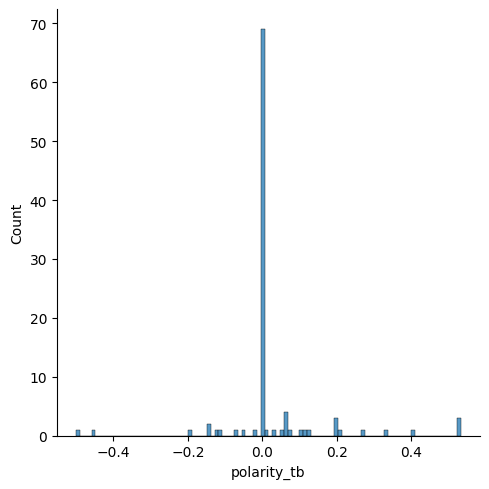

polarity_sia


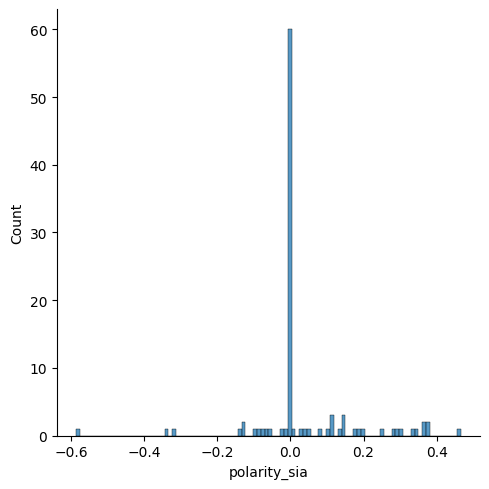

word_count


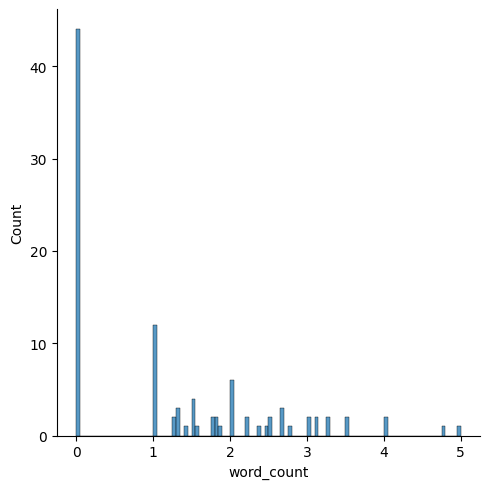

avg_word_length


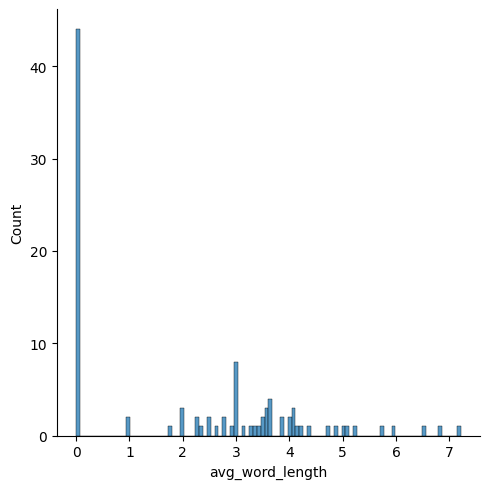

In [9]:
for metric in dota_per_min.columns[6:]:
    print(metric)
    sns.displot(dota_per_min, x=metric, bins=100)
    plt.show()

It looks like all of the distributions are what we would expect:

- Some of the variables have a significant number of values at 0 for games where
    - the losing team is stomped, or
    - that end at an early surrender when the victor is clear.

    (Both scenarios are quite common, so we will keep them in.)

- Chat sentiment metrics have a significant number of values at 0 because this is how we chose to treat users who do not chat.

- The inhibitor distribution has two peaks, which makes sense because the dota in-game map has three "lanes" by which to enter the enemy base. Destroying inhibitors in a lane creates stronger allied non-player units ("minions") in that lane. In closer games, you will want to destroy inhibitors in multiple lanes to make destroying the enemy base easier. Otherwise, you may be able to win only through a single lane.

- Outside of these two specific scenarios, distributions all appear to be normal.

### Outlier removal

There are a few major outliers in metrics that (from our pre-existing game knowledge) we believe inutitively shouldn't have much variation. For example, Roshan being taken more than twice per match is very rare, and is a good indication of a very exceptional game.

In [10]:
dota_reg = dota_per_min.copy()
print("Before outlier removal: " + str(dota_per_min.shape[0]))
for field in ["aegis", "roshan_kill"]:
    dota_reg = dota_reg[
        (dota_reg[field] <= dota_reg[field].mean() + dota_reg[field].std() * 3)
        & (dota_reg[field] >= dota_reg[field].mean() - dota_reg[field].std() * 3)
    ].reset_index(drop=True)
print("After outlier removal: " + str(dota_reg.shape[0]))

Before outlier removal: 100
After outlier removal: 96


<a id="scale"></a>
## Center values at 0 and scale them to between -1 and 1

In [11]:
dota = dota_reg.copy()
for i in dota.columns[6:]:
    dota[i] = dota[i] - np.mean(dota[i])  # Center values
    dota[i] = dota[i] / np.max(
        [np.nanmax(dota[i]), np.nanmin(dota[i]) * -1]
    )  # Scale values
dota.head()

,match_id,team,player_slot,hero_id,duration,winner,turret_count,inhib_count,aegis,roshan_kill,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
0,312,blue,2.0,14.0,2760.0,True,0.084344,0.172149,0.146017,0.147172,...,-0.068729,-0.078315,0.196533,-0.05959,-0.064395,0.071045,-0.324026,-0.151587,0.508385,0.353331
1,2475,blue,1.0,101.0,2725.0,True,-0.014873,0.179302,1.000000,1.000000,...,-0.046951,-0.327540,0.078109,-0.05959,-0.023779,-0.261482,0.972255,0.473703,0.038620,0.282054
2,2676,blue,0.0,32.0,3743.0,False,-0.236644,-0.179440,0.344900,0.345787,...,-0.100324,-0.222815,-0.425024,-0.05959,-0.061757,-0.413907,-0.045683,-0.058439,-0.310973,-0.394472
3,2753,blue,3.0,32.0,2440.0,True,0.189374,0.245187,-0.272904,-0.271182,...,-0.130873,-0.201897,0.045836,-0.05959,-0.033349,0.014826,-0.259268,-0.261488,1.000000,0.749179
4,4527,blue,0.0,62.0,2133.0,False,-0.208116,-0.144561,-0.272904,-0.271182,...,-0.104069,-0.305232,-0.135462,-0.05959,-0.081832,-0.182609,-0.045683,-0.058439,0.606708,0.040438


<a id="check"></a>
## Check for missing values / sanity check

In [12]:
# We can firstly exclude rows that don't have durations
dota = dota[dota["duration"].notnull()]
# Check to see how many other rows have missing values
print("Number of rows: " + str(dota.shape[0]))
print("Number of rows without missing values: " + str(dota.notnull().shape[0]))

Number of rows: 96
Number of rows without missing values: 96


In [13]:
dota.isna().sum()

match_id           0
team               0
player_slot        0
hero_id            0
duration           0
winner             0
turret_count       0
inhib_count        0
aegis              0
roshan_kill        0
firstblood         0
gold               0
gold_spent         0
xp                 0
kills              0
deaths             0
assists            0
denies             0
last_hits          0
hero_damage        0
hero_healing       0
tower_damage       0
level              0
polarity_tb        0
polarity_sia       0
word_count         0
avg_word_length    0
dtype: int64

In [14]:
dota.describe()

,match_id,player_slot,hero_id,duration,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
count,96.000000,96.0000,96.000000,96.000000,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,...,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01
mean,24126.645833,55.4375,51.906250,2402.041667,-1.850372e-17,6.013708e-17,-2.775558e-17,-3.238150e-17,-2.775558e-17,-1.387779e-17,...,9.251859e-18,1.850372e-17,-6.071532e-18,1.387779e-17,-2.312965e-18,-2.844947e-16,-4.625929e-18,-4.625929e-18,-3.932040e-17,-1.619075e-17
std,13947.022488,63.5333,35.167293,549.224907,3.070269e-01,3.441085e-01,3.723985e-01,3.698068e-01,5.163204e-01,1.728927e-01,...,1.935430e-01,3.215144e-01,3.777639e-01,1.655832e-01,1.662769e-01,3.699463e-01,2.722082e-01,2.380498e-01,3.345336e-01,3.917838e-01
min,312.000000,0.0000,3.000000,1110.000000,-2.744374e-01,-3.847691e-01,-2.729041e-01,-2.711821e-01,-4.829888e-01,-1.533230e-01,...,-1.308726e-01,-4.121090e-01,-6.457607e-01,-5.959047e-02,-8.183158e-02,-6.770381e-01,-1.000000e+00,-1.000000e+00,-3.109728e-01,-3.944720e-01
25%,11454.750000,2.0000,18.250000,2030.500000,-2.744374e-01,-3.847691e-01,-2.729041e-01,-2.711821e-01,-4.829888e-01,-9.904517e-02,...,-1.052591e-01,-2.293006e-01,-2.877388e-01,-5.959047e-02,-7.593698e-02,-2.666524e-01,-4.568314e-02,-5.843928e-02,-3.109728e-01,-3.944720e-01
50%,23635.500000,4.0000,50.000000,2328.500000,-1.218628e-01,-9.574472e-02,-2.729041e-01,-2.711821e-01,-4.829888e-01,-5.160314e-02,...,-4.693519e-02,-8.428379e-02,-9.720028e-02,-5.959047e-02,-5.558613e-02,-8.093572e-02,-4.568314e-02,-5.843928e-02,-4.877824e-02,4.043761e-02
75%,36098.750000,130.0000,84.000000,2763.750000,1.921549e-01,2.805825e-01,2.810409e-01,2.820135e-01,5.401922e-01,2.957457e-02,...,7.746165e-03,1.563161e-01,2.174525e-01,-5.726412e-02,-1.233352e-02,2.228320e-01,-4.568314e-02,7.026672e-03,2.134163e-01,2.967121e-01
max,49618.000000,132.0000,112.000000,3743.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.722548e-01,6.902775e-01,1.000000e+00,1.000000e+00


It looks like every row that has a duration has all of its values recorded (i.e. no missing values). In addition, all the values seem reasonable. However, some of the values being right-skewed (low mean) may lower their weightings in a machine learning setting, which we will have to try and accommodate.

<a id="explo"></a>
# Data exploration

We've already had a look at the shape of each of the features individually. However, there are two other considerations before we can begin modelling:

1. Whether independent variables are related to each other, and
2. How independent variables relate to the dependent variable (victory).

<a id="heatmap"></a>
## Correlation heatmaps

One important step in visual inspection is to check for **colinearity**.

Note that these two heatmaps were already included in milestone 1. (The rest of the data exploration section is for milestone 2.)

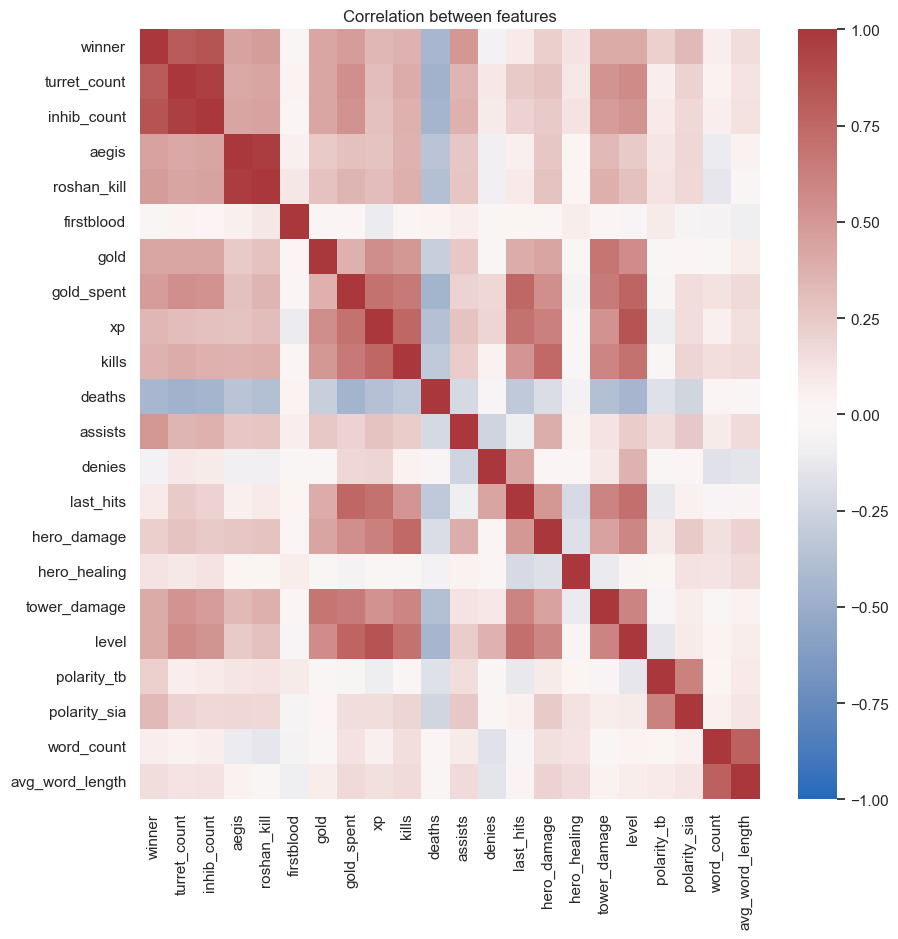

In [15]:
corr_columns = list(dota.columns[5:])
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(dota[corr_columns].corr(), vmin=-1, vmax=1, cmap="vlag").set_title(
    "Correlation between features"
)
plt.show()

The "deaths" field is the only heavily negative correlation from other metrics, so let's try to zoom in on the remaining metrics:

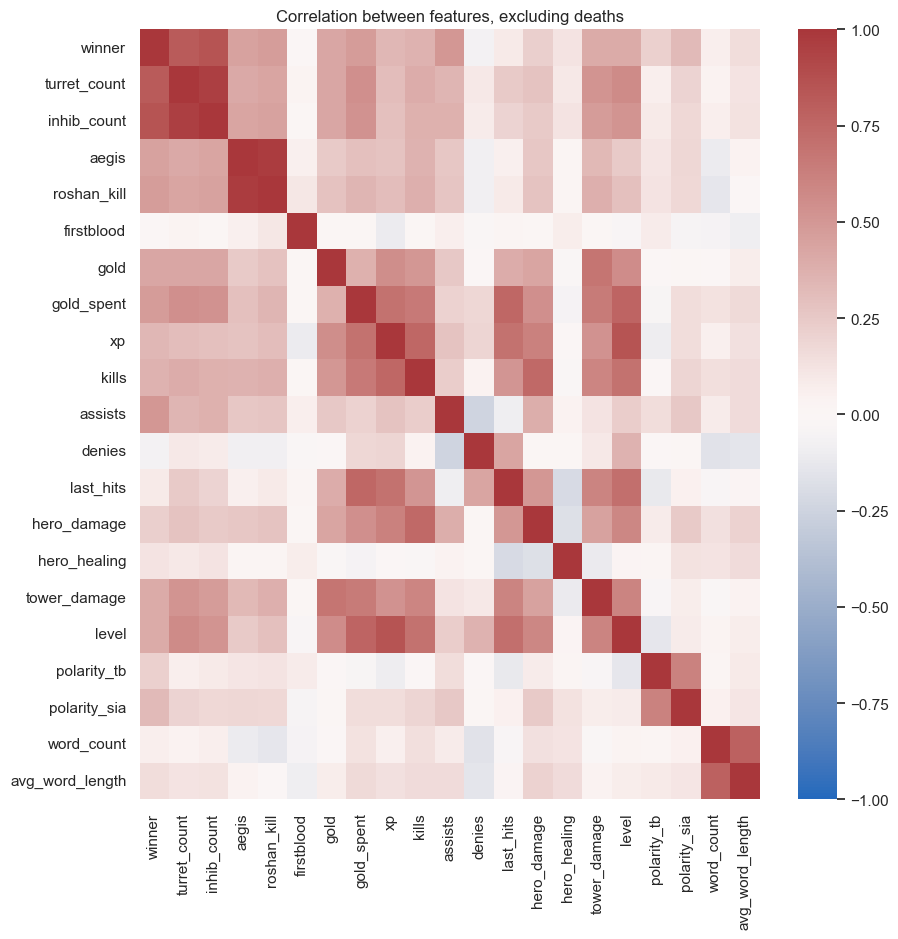

In [16]:
corr_columns.remove("deaths")
sns.heatmap(dota[corr_columns].corr(), vmin=-1, vmax=1, cmap="vlag").set_title(
    "Correlation between features, excluding deaths"
)
plt.show()

Now it's clear that almost all of the original (in-game metric) variables have a positive correlation to winning the game and to each other. On the other hand, chat sentiment features have a weak correlation to the original in-game metrics, but high correlation with each other.

The correlation heatmaps above clearly show that some variables are highly correlated. For example, the following two objectives are highly correlated:

- **Roshan**, which is a neutral monster that either team can kill to earn a significant amount of gold; and
- the **Aegis**, which is a buff that Roshan drops when killed. Any player on either team can pick up the Aegis to earn signicant numeric bonuses, but it is most likely to be picked up by a member of the team killing Roshan, since they are closer to the buff when it is dropped.

We will have to be careful about colinearity (and multicolinearity) when choosing our models.

<a id="corr_win"></a>
## Correlation to winning

It's also worth considering the type of relationship between our predictor features and winning. For example, if the relationship between tower destruction and winning looks like it's quadratic, we wouldn't want to use linear regression since it wouldn't accurately capture the relationship.

Intuitively (based on domain knowledge), we would expect the following:

- All of the original metrics (from players.csv and objectives.csv) *should* have a linear relationship with winning, although their slopes may be different. This is because they are objectives we aim to obtain in a game - when deciding whether to pursue an objective based on its cost/benefit analysis, the only cost is its opportunity cost. For example, even though the correlation between winning and number of denies is relatively weak, we expect that, all else held equal (including heroes), being able to deny an opponent more often than they can deny you would improve your win chances; there are no scenarios where (again, all else held equal) you would rather not deny your opponent.
- The appended metrics from our unsupervised analysis (for type of hero choice) should have a close to random relationship with winning; the game developers are explicitly incentivized to make the viability of all heroes as balanced as possible, and aiming for a random relationship to winning is the easiest way to achieve this. This is supported by analyses on both Dota and other MOBAs that were much better funded than this project.
- Developer statements would lead us to believe that chat polarity has a (positive) linear relationship with winning, but they are incentivized to claim this to try and make the game less toxic, and there have been few public analyses supporting this.
 
We manually inspect differences in distributions (using boxplots) of each feature between winning and losing players to decide whether these assumptions are reasonable.

turret_count


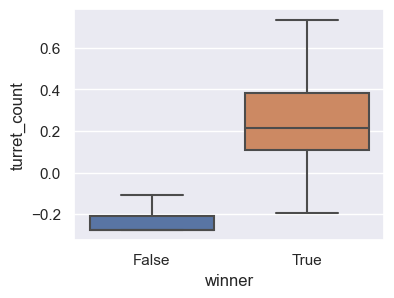

inhib_count


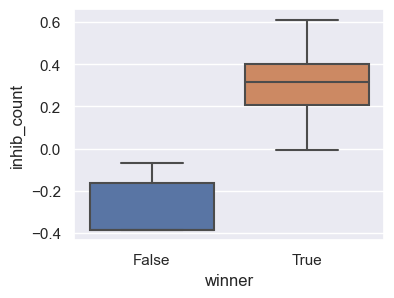

aegis


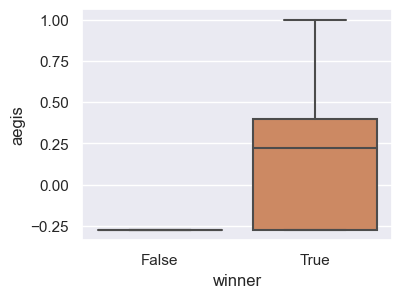

roshan_kill


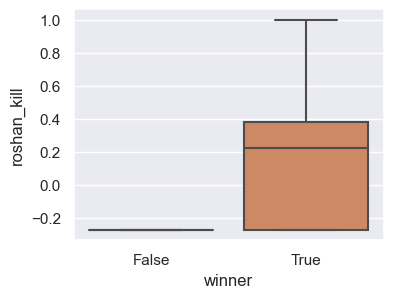

firstblood


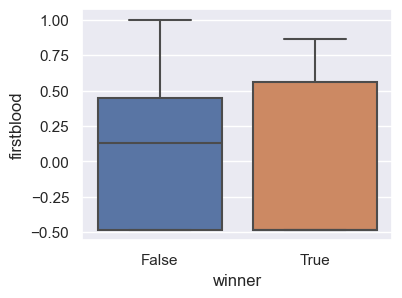

gold


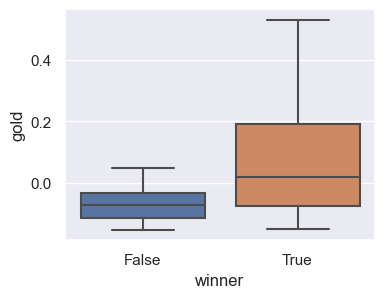

gold_spent


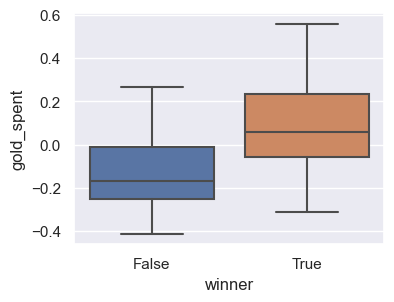

xp


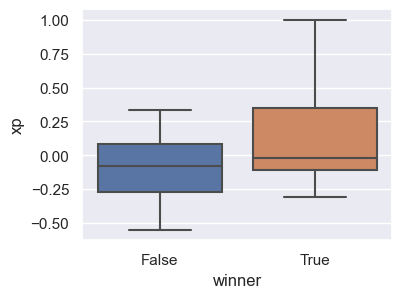

kills


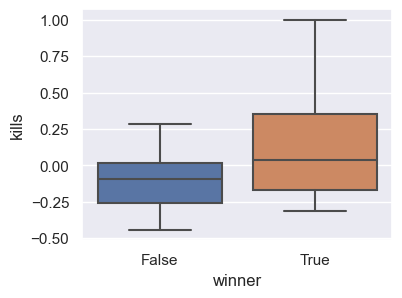

deaths


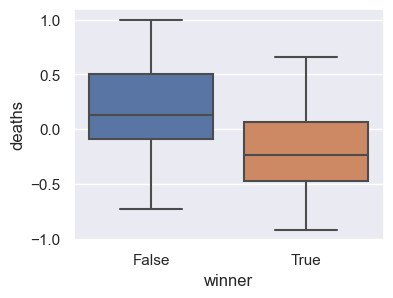

assists


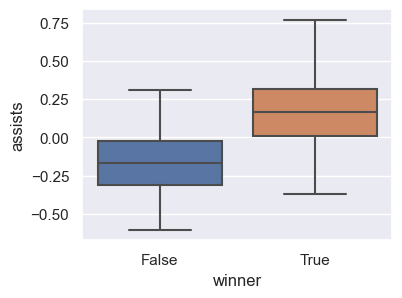

denies


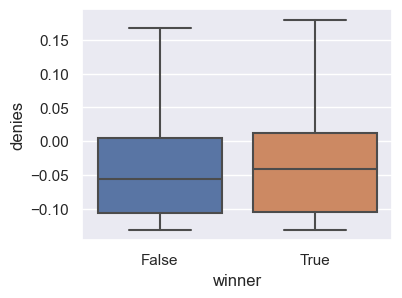

last_hits


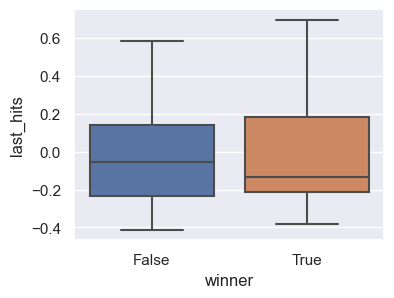

hero_damage


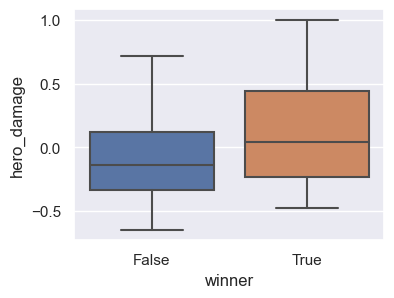

hero_healing


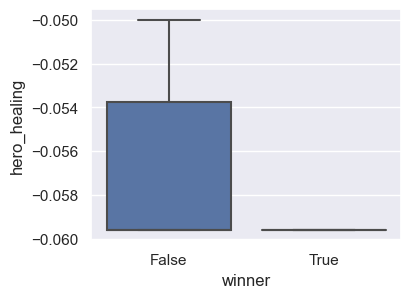

tower_damage


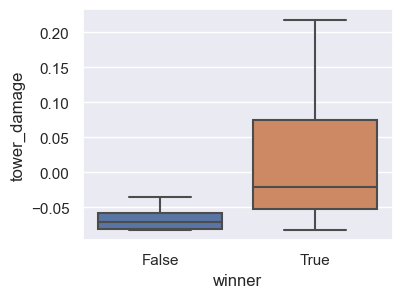

level


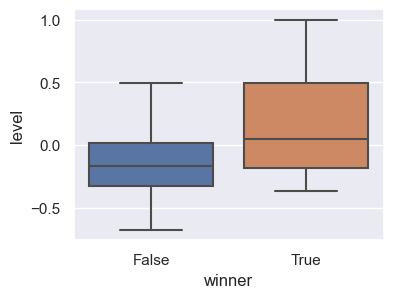

polarity_tb


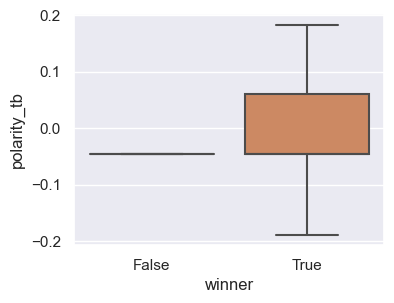

polarity_sia


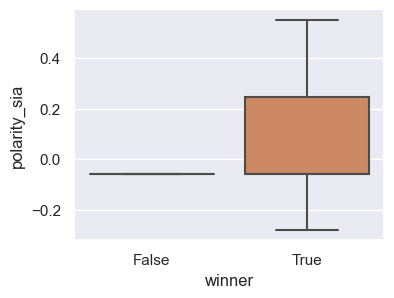

word_count


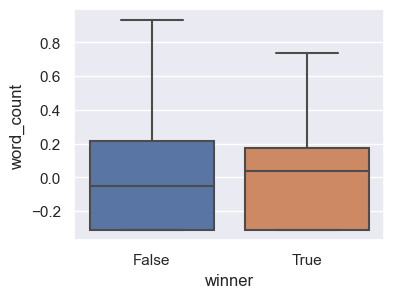

avg_word_length


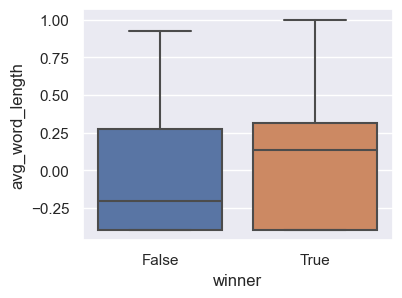

In [17]:
sns.set(rc={"figure.figsize": (4, 3)})
for metric in dota.columns[6:]:
    print(metric)
    sns.boxplot(data=dota, x="winner", y=metric, showfliers=False)
    plt.show()

As expected, for the vast majority of the features from the original metrics (players.csv and objectives.csv), the overlap in value between winners and losers is little to none, indicating a likely linear relationship. For some metrics (like first blood), a linear relationship isn't obvious, but searching for an appropriate non-linear relationship seems infeasible given that a) through domain knowledge, intuitively we would still expect a linear relationship, just a very weak one mostly hidden by variance; and b) our sample size (roughly 50k observations) is small enough that we risk overfitting and finding spurious correlations.

High chat polarity (positive sentiment) does indeed seem to increase linearly with win chances, although chattiness (e.g. measured by word count) does not.

<a id="model"></a>
# Modelling

We now have three things to consider when choosing which supervised model to use:

1. Some features are highly correlated, and we don't have an easy way to decide which correlated features to exclude. This means we can rule out models like K-NN and Naive Bayes that assume otherwise.
2. Most of the features have a linear relationship to winning. This means we can assume that using highly complex models that offer substantially better performance for non-linear relationships should not be necessary.
3. We want our models to be relatively interpretable. Players should ideally be able to understand *why* the model suggests they focus on a given objective for them to understand which areas of gameplay to focus on, since our set of features does not cover every in-game scenario, and players will need to make decisions on the fly. This rules out some of the more powerful techniques, like neural networks and ensemble learning.

Overall, the following models will be implemented and analyzed:

- Lasso regression
- Decision tree

We will also train a neural network (MLP classifier) model for benchmarking purposes, since it should normally be substantially more powerful than lasso regression or a single decision tree. However, it will not be further analyzed due to its lack of interpretability.

We will perform a grid search for each of these models to tune their parameters. Afterwards, we will compare the models based on their best performing parameters.


In [18]:
grids = dict()

**Note: because of how slow the grid search is, we have run the code for the grid search once, commented it out, pickled the results, and hard-coded the best parameters that we found from it for the remainder of the notebook. The next block of code simply loads the pickle of the results.** (The warnings are because we ran the grid search on Great Lakes. Since we are only using the results of a model that has already been run and not conducting any further modelling, they can be safely ignored.)

In [19]:
with open("../intermediate/grids.pickle", "rb") as grids_file:
    grids = pickle.load(grids_file)

C:\Users\foong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\foong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\foong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.

<a id="parameters"></a>
## Parameter choices

**Evaluation**:

We explicitly choose to evaluate on accuracy because we have perfectly balanced data and care equally about false positives and false negatives. With this in mind:

- Precision wouldn't be ideal because it fails to consider false negatives.
- Recall wouldn't be ideal because it fails to consider false positives.
- Other metrics like F1 score and AUC could be justifiable, but there are no substantial benefits to using these (slightly) more complex and less intuitive metrics over accuracy.

**Choice of parameters**:

The choice of intervals used for each parameter, as well as the choice of 5-fold validation, are somewhat arbitrary, but should be granular enough to arrive at relatively close to the best-performing parameters.

In [20]:
random_state = 42
kfold = 5

<a id="split"></a>
## Train/test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    dota.iloc[:, 6:], dota.iloc[:, 5], random_state=random_state
)

<a id="lasso"></a>
## Lasso regression

Note that we use logistic regression (as opposed to linear regression) to confine the outcome to between 0 and 1.

In [22]:
regression_params = {
    "random_state": [random_state],
    "penalty": ["l1"],  # lasso
    "solver": ["liblinear"],  # supports lasso
    "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "tol": [0.00001, 0.0001, 0.001, 0.01],
}

# grids["regression"] = GridSearchCV(
#     estimator=LogisticRegression(),
#     param_grid=regression_params,
#     scoring="accuracy",
#     cv=kfold,
#     verbose=1,
# ).fit(X_train, y_train)

# grids["regression"].best_params_

<a id="tree"></a>
## Decision tree

In [23]:
tree_params = {
    "random_state": [random_state],
    "max_depth": [None, 1, 2, 5, 10, 50],
    "min_samples_leaf": [1, 2, 5, 10, 50],
    "max_leaf_nodes": [None, 2, 10, 50],
    "max_features": ["sqrt", "log2", None],
}

# grids["decision_tree"] = GridSearchCV(
#     estimator=DecisionTreeClassifier(),
#     param_grid=tree_params,
#     scoring="accuracy",
#     cv=kfold,
#     verbose=1,
# ).fit(X_train, y_train)

# grids["decision_tree"].best_params_

<a id="mlp"></a>
## Multi-layer perceptron

In [24]:
nn_params = {
    "random_state": [random_state],
    "hidden_layer_sizes": [(50, 50), (100,)],
    "alpha": [0.001, 0.01],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

# grids["neural_network"] = GridSearchCV(
#     estimator=MLPClassifier(),
#     param_grid=nn_params,
#     scoring="accuracy",
#     cv=kfold,
#     verbose=1,
# ).fit(X_train, y_train)

# grids["neural_network"].best_params_

<a id="results"></a>
## Results

In [25]:
# Dictionary used to assign colours to features
feature_category_map = {
    "turret_count": "building-related",
    "inhib_count": "building-related",
    "aegis": "monster-related",
    "roshan_kill": "monster-related",
    "firstblood": "kill-related",
    "gold": "gold-related",
    "gold_spent": "gold-related",
    "kills": "kill-related",
    "deaths": "death-related",
    "assists": "kill-related",
    "denies": "deny-related",
    "last_hits": "minion-related",
    "hero_damage": "damage-related",
    "hero_healing": "healing-related",
    "tower_damage": "building-related",
    "level": "level-related",
    "xp": "level-related",
    "polarity_tb": "polarity-related",
    "polarity_sia": "polarity-related",
    "word_count": "chattiness-related",
    "avg_word_length": "chattiness-related",
}

In [26]:
best_regression = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, tol=0.001, random_state=random_state
)

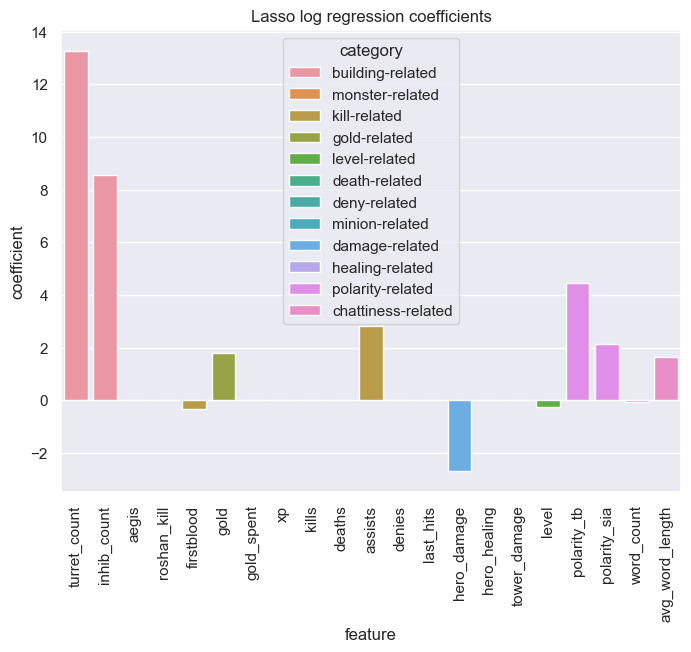

In [27]:
regression_coefficients = pd.DataFrame(
    {
        "feature": dota.columns[6:],
        "coefficient": best_regression.fit(X_train, y_train).coef_[0],
    }
)

regression_coefficients["category"] = [
    feature_category_map[x] for x in regression_coefficients["feature"]
]

sns.set(rc={"figure.figsize": (8, 6)})
sns.barplot(
    data=regression_coefficients,
    x="feature",
    y="coefficient",
    hue="category",
    dodge=False,
).set_title("Lasso log regression coefficients")
plt.xticks(rotation=90)
plt.show()

In [28]:
best_tree = DecisionTreeClassifier(
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_leaf=10,
    random_state=random_state,
)

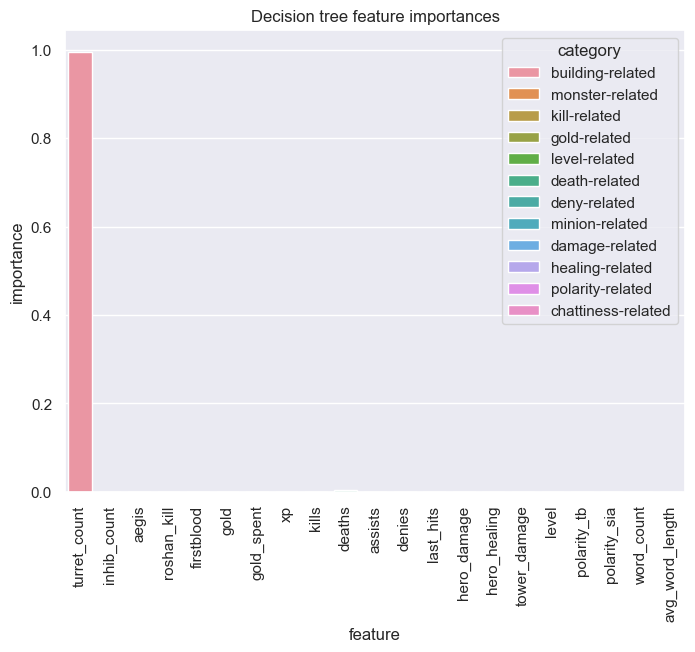

In [29]:
tree_importances = pd.DataFrame(
    {
        "feature": dota.columns[6:],
        "importance": best_tree.fit(X_train, y_train).feature_importances_,
    }
)

tree_importances["category"] = [
    feature_category_map[x] for x in tree_importances["feature"]
]

sns.set(rc={"figure.figsize": (8, 6)})
sns.barplot(
    data=tree_importances, x="feature", y="importance", hue="category", dodge=False
).set_title("Decision tree feature importances")
plt.xticks(rotation=90)
plt.show()

In [30]:
model_feature_comparison_tb = regression_coefficients.merge(tree_importances).drop(columns = "category")
model_feature_comparison_tb.columns = ["feature", "regression coefficient", "decision tree importance"]
model_feature_comparison_tb

,feature,regression coefficient,decision tree importance
0,turret_count,13.267727,0.995582
1,inhib_count,8.569079,0.000000
2,aegis,0.000000,0.000000
3,roshan_kill,0.000000,0.000000
4,firstblood,-0.313954,0.000000
5,gold,1.800778,0.000000
6,gold_spent,0.000000,0.000000
7,xp,0.000000,0.000000
8,kills,0.000000,0.000000
9,deaths,0.000000,0.004418


In [31]:
print("Decision tree feature importance")
print("ordered by Gini importance")
model_feature_comparison_tb[["feature", "decision tree importance"]].sort_values("decision tree importance", ascending = False)



Decision tree feature importance
ordered by Gini importance


,feature,decision tree importance
0,turret_count,0.995582
9,deaths,0.004418
11,denies,0.000000
19,word_count,0.000000
18,polarity_sia,0.000000
17,polarity_tb,0.000000
16,level,0.000000
15,tower_damage,0.000000
14,hero_healing,0.000000
13,hero_damage,0.000000


In [32]:
model_summary = pd.DataFrame(
    {
        "model": list(grids.keys()),
        "training accuracy": [grids[model].best_score_ for model in grids.keys()],
        "training std": [grids[model].cv_results_["std_test_score"][grids[model].best_index_] for model in grids.keys()],
        "test accuracy": [
            accuracy_score(grids[model].predict(X_test.values), y_test)
            for model in grids.keys()
        ],
    }
)

model_summary

,model,training accuracy,training std,test accuracy
0,regression,0.972667,0.000562,0.958333
1,decision_tree,0.971156,0.000435,0.875000
2,neural_network,0.980376,0.001119,0.958333


It looks like both the regression and decision tree perform nearly equally well, with around 97% accuracy. Neural networks perform slightly better, with around 98% accuracy. This may be indicative of some of the variable relationships not being purely linear. However, we believe it is more likely due to its ability to better capture any more complex interactions between features, given the high degree of collinearity we saw earlier (though this hypothesis isn't easily testable on our dataset).

<a id="analysis"></a>
# Model analysis

<a id="sensitivity"></a>
## Parameter tuning sensitivity

We first analyze how sensitive the model is to parameters to see whether our grid search parameters were sufficient.

In [33]:
# Helper function to plot distribution of each parameter's mean test score (holding other parameters constant)
def plot_parameter_distribution(grid_results, params, best_params):
    # Loop through each parameter to plot (if we grid searched on more than one value)
    for param_to_plot in params.keys():
        if len(params[param_to_plot]) > 1:
            grid_results_filtered = grid_results.copy()
            # Loop through other parameters and filter them to best value
            for param in best_params.keys():
                if param != param_to_plot:
                    if best_params[param] is None:
                        grid_results_filtered = grid_results_filtered[
                            grid_results_filtered["param_" + param].isnull()
                        ].reset_index(drop=True)
                    else:
                        grid_results_filtered = grid_results_filtered[
                            grid_results_filtered["param_" + param]
                            == best_params[param]
                        ].reset_index(drop=True)
            # Plot test scores of current parameter
            ax = sns.barplot(
                data=grid_results_filtered,
                x="param_" + param_to_plot,
                y="mean_test_score"
            )
            ax.set(xlabel = "Parameter " + param_to_plot, ylabel = "Mean accuracy")
            ax.bar_label(ax.containers[0], fmt='%.2f')
            plt.show()

### Regression parameter sensitivity

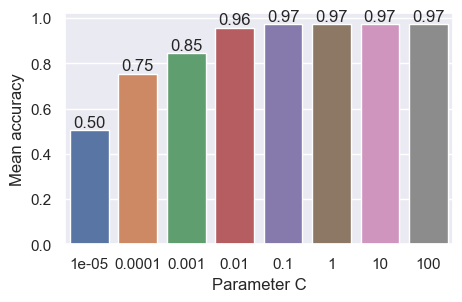

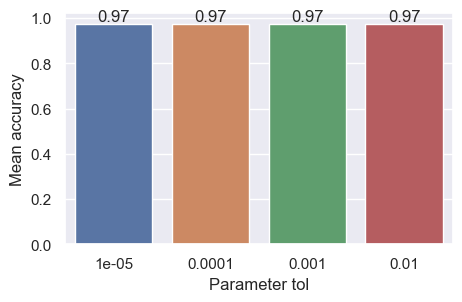

In [34]:
regression_results = pd.DataFrame(grids["regression"].cv_results_)
sns.set(rc={"figure.figsize": (5, 3)})
plot_parameter_distribution(
    regression_results, regression_params, grids["regression"].best_params_
)

### Decision tree parameter sensivity

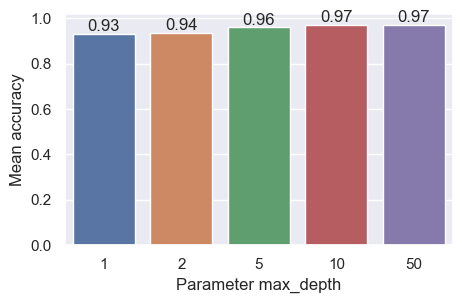

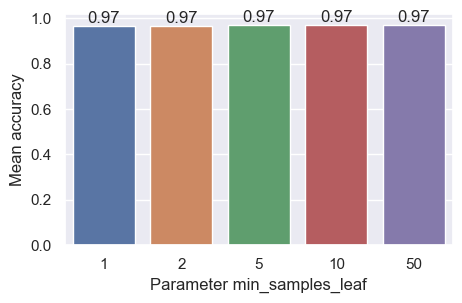

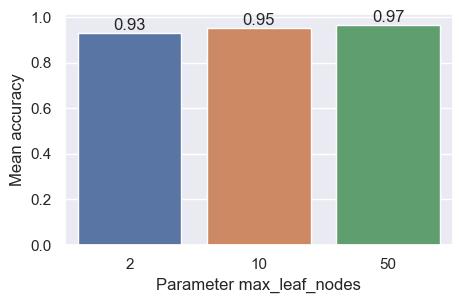

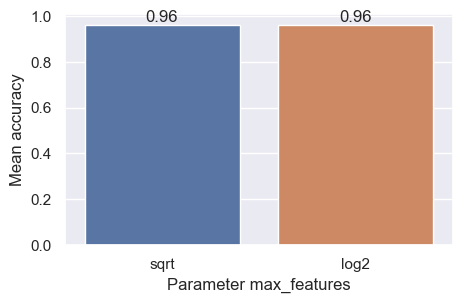

In [35]:
tree_results = pd.DataFrame(grids["decision_tree"].cv_results_)
plot_parameter_distribution(
    tree_results, tree_params, grids["decision_tree"].best_params_
)

It doesn't seem like either of our models are highly sensitive to parameter choice, which gives us confidence that our model performance is fairly close to being optimal.

<a id="importance"></a>
## Feature importance

Next, we check which features each model type finds to be important (using the optimal parameters we found above for consistency).

In [36]:
def feature_importance(model):
    dropped_list = [
        np.NaN
    ]  # Store features being dropped and associated accuracies in a table
    accuracy_list = []

    # Fit the model on the full data
    all_features = model.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(all_features.predict(X_test), y_test))
    print("Test accuracy with all features: " + str(accuracy_list[-1]))

    # Loop through each feature
    for feature in dota.columns[6:]:
        # Fit the model with that feature dropped
        dropped_list.append(feature)
        dota_dropped = dota.drop(columns=feature)
        (
            X_train_dropped,
            X_test_dropped,
            y_train_dropped,
            y_test_dropped,
        ) = train_test_split(
            dota_dropped.iloc[:, 6:], dota_dropped.iloc[:, 5], random_state=random_state
        )
        features_dropped = model.fit(X_train_dropped, y_train_dropped)
        accuracy_list.append(
            accuracy_score(features_dropped.predict(X_test_dropped), y_test_dropped)
        )
        print("Test accuracy with " + feature + " dropped: " + str(accuracy_list[-1]))

    # Format output table
    feature_importance_tb = pd.DataFrame(
        {"Feature dropped": dropped_list, "Accuracy": accuracy_list}
    ).sort_values(by="Accuracy", ascending=True)

    return feature_importance_tb

### Lasso regression feature importance

To check feature importance for regression, we remove each feature and see how much accuracy decreases. We use the parameters from the parameter tuning above.

In [37]:
regression_feature_importance_tb = feature_importance(best_regression)
regression_feature_importance_tb

Test accuracy with all features: 0.9583333333333334
Test accuracy with turret_count dropped: 0.9583333333333334
Test accuracy with inhib_count dropped: 1.0
Test accuracy with aegis dropped: 0.9583333333333334
Test accuracy with roshan_kill dropped: 0.9583333333333334
Test accuracy with firstblood dropped: 0.9583333333333334
Test accuracy with gold dropped: 0.9583333333333334
Test accuracy with gold_spent dropped: 0.9583333333333334
Test accuracy with xp dropped: 0.9583333333333334
Test accuracy with kills dropped: 0.9583333333333334
Test accuracy with deaths dropped: 0.9583333333333334
Test accuracy with assists dropped: 0.9583333333333334
Test accuracy with denies dropped: 0.9583333333333334
Test accuracy with last_hits dropped: 0.9583333333333334
Test accuracy with hero_damage dropped: 0.9583333333333334
Test accuracy with hero_healing dropped: 0.9583333333333334
Test accuracy with tower_damage dropped: 0.9583333333333334
Test accuracy with level dropped: 0.9583333333333334
Test accu

,Feature dropped,Accuracy
0,NaN,0.958333
19,polarity_sia,0.958333
18,polarity_tb,0.958333
17,level,0.958333
16,tower_damage,0.958333
15,hero_healing,0.958333
14,hero_damage,0.958333
13,last_hits,0.958333
12,denies,0.958333
11,assists,0.958333


Level and xp seem like the strongest predictors of victory based on this analysis, with a substantial drop in victory from the removal of either. In general, though, it seems like most of the drops in accuracy from feature removal are close to being spurious (with there even being a couple of features that increase accuracy once removed).

### Decision tree feature importance

We do the same for decision trees. Decision trees already have a built-in feature_importances_ attribute, but this is conceptually more similar to regression coefficient size and isn't as meaningful for figuring out if any features are being especially relied upon.

In [38]:
tree_feature_importance_tb = feature_importance(best_tree)
tree_feature_importance_tb

Test accuracy with all features: 0.9583333333333334
Test accuracy with turret_count dropped: 0.9583333333333334
Test accuracy with inhib_count dropped: 0.9583333333333334
Test accuracy with aegis dropped: 0.9583333333333334
Test accuracy with roshan_kill dropped: 0.9583333333333334
Test accuracy with firstblood dropped: 0.9583333333333334
Test accuracy with gold dropped: 0.9583333333333334
Test accuracy with gold_spent dropped: 0.9583333333333334
Test accuracy with xp dropped: 0.9583333333333334
Test accuracy with kills dropped: 0.9583333333333334
Test accuracy with deaths dropped: 0.9583333333333334
Test accuracy with assists dropped: 0.9583333333333334
Test accuracy with denies dropped: 0.9583333333333334
Test accuracy with last_hits dropped: 0.9583333333333334
Test accuracy with hero_damage dropped: 0.9583333333333334
Test accuracy with hero_healing dropped: 0.9583333333333334
Test accuracy with tower_damage dropped: 0.9583333333333334
Test accuracy with level dropped: 0.95833333333

,Feature dropped,Accuracy
0,NaN,0.958333
19,polarity_sia,0.958333
18,polarity_tb,0.958333
17,level,0.958333
16,tower_damage,0.958333
15,hero_healing,0.958333
14,hero_damage,0.958333
13,last_hits,0.958333
12,denies,0.958333
11,assists,0.958333


The decision tree feature importance is similar but not identical. Again, most of the decreases in accuracy are very low, and nearly half of the features improve accuracy once removed.

The minimal decreases in accuracy stemming from dropping features in both models demonstrates that no one feature is especially important - the information provided by any one feature can largely be substitued by other features. This leads us to conclude that there are many overlapping features, which is supported by the high correlations between features that we saw earlier.

<a id="ablation"></a>
## Feature ablation

Since removing features one by one didn't give us much insight into feature importance, we instead remove intuitively similar groups of features (based on our prior knowledge).

In [39]:
# Dictionary used to group features together
# This just flips the feature_category_map dictionary we defined for plot colours earlier
category_feature_map = dict()
for i in set(feature_category_map.values()):
    category_feature_map[i] = []
for i in feature_category_map.keys():
    category_feature_map[feature_category_map[i]].append(i)

category_feature_map

{'minion-related': ['last_hits'],
 'building-related': ['turret_count', 'inhib_count', 'tower_damage'],
 'healing-related': ['hero_healing'],
 'chattiness-related': ['word_count', 'avg_word_length'],
 'monster-related': ['aegis', 'roshan_kill'],
 'death-related': ['deaths'],
 'deny-related': ['denies'],
 'damage-related': ['hero_damage'],
 'level-related': ['level', 'xp'],
 'gold-related': ['gold', 'gold_spent'],
 'kill-related': ['firstblood', 'kills', 'assists'],
 'polarity-related': ['polarity_tb', 'polarity_sia']}

In [40]:
def feature_ablation(model):
    dropped_list = [
        np.NaN
    ]  # Store features being dropped and associated accuracies in a table
    accuracy_list = []

    # Fit the model on the full data
    all_features = model.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(all_features.predict(X_test), y_test))
    print("Test accuracy with all features: " + str(accuracy_list[-1]))

    # Loop through each category of features
    for feature_category in category_feature_map.keys():
        # Fit the model with those features dropped dropped
        dropped_list.append(feature_category)
        dota_dropped = dota.copy()
        for feature in category_feature_map[feature_category]:
            dota_dropped = dota_dropped.drop(columns=feature)
        (
            X_train_dropped,
            X_test_dropped,
            y_train_dropped,
            y_test_dropped,
        ) = train_test_split(
            dota_dropped.iloc[:, 6:], dota_dropped.iloc[:, 5], random_state=random_state
        )
        features_dropped = model.fit(X_train_dropped, y_train_dropped)
        accuracy_list.append(
            accuracy_score(features_dropped.predict(X_test_dropped), y_test_dropped)
        )
        print(
            "Test accuracy with "
            + feature_category
            + " features dropped: "
            + str(accuracy_list[-1])
        )

    # Format output table
    feature_ablation_tb = pd.DataFrame(
        {"Feature dropped": dropped_list, "Accuracy": accuracy_list}
    ).sort_values(by="Accuracy", ascending=True)

    return feature_ablation_tb

### Lasso regression feature ablation

In [41]:
regression_feature_ablation_tb = feature_ablation(best_regression)
regression_feature_ablation_tb

Test accuracy with all features: 0.9583333333333334
Test accuracy with minion-related features dropped: 0.9583333333333334
Test accuracy with building-related features dropped: 0.9583333333333334
Test accuracy with healing-related features dropped: 0.9583333333333334
Test accuracy with chattiness-related features dropped: 0.9583333333333334
Test accuracy with monster-related features dropped: 0.9583333333333334
Test accuracy with death-related features dropped: 0.9583333333333334
Test accuracy with deny-related features dropped: 0.9583333333333334
Test accuracy with damage-related features dropped: 0.9583333333333334
Test accuracy with level-related features dropped: 0.9583333333333334
Test accuracy with gold-related features dropped: 0.9583333333333334
Test accuracy with kill-related features dropped: 0.9583333333333334
Test accuracy with polarity-related features dropped: 0.9583333333333334


,Feature dropped,Accuracy
0,NaN,0.958333
1,minion-related,0.958333
2,building-related,0.958333
3,healing-related,0.958333
4,chattiness-related,0.958333
5,monster-related,0.958333
6,death-related,0.958333
7,deny-related,0.958333
8,damage-related,0.958333
9,level-related,0.958333


In [42]:
print("Regression feature importance")
print("ordered by post-removal accuracy")
regression_feature_importance_tb

Regression feature importance
ordered by post-removal accuracy


,Feature dropped,Accuracy
0,NaN,0.958333
19,polarity_sia,0.958333
18,polarity_tb,0.958333
17,level,0.958333
16,tower_damage,0.958333
15,hero_healing,0.958333
14,hero_damage,0.958333
13,last_hits,0.958333
12,denies,0.958333
11,assists,0.958333


### Decision tree feature ablation

In [43]:
tree_feature_ablation_tb = feature_ablation(best_tree)
tree_feature_ablation_tb

Test accuracy with all features: 0.9583333333333334
Test accuracy with minion-related features dropped: 0.9583333333333334
Test accuracy with building-related features dropped: 0.75
Test accuracy with healing-related features dropped: 0.9583333333333334
Test accuracy with chattiness-related features dropped: 0.9583333333333334
Test accuracy with monster-related features dropped: 0.9583333333333334
Test accuracy with death-related features dropped: 0.9583333333333334
Test accuracy with deny-related features dropped: 0.9583333333333334
Test accuracy with damage-related features dropped: 0.9583333333333334
Test accuracy with level-related features dropped: 0.9583333333333334
Test accuracy with gold-related features dropped: 0.9583333333333334
Test accuracy with kill-related features dropped: 0.9583333333333334
Test accuracy with polarity-related features dropped: 0.9583333333333334


,Feature dropped,Accuracy
2,building-related,0.750000
0,NaN,0.958333
1,minion-related,0.958333
3,healing-related,0.958333
4,chattiness-related,0.958333
5,monster-related,0.958333
6,death-related,0.958333
7,deny-related,0.958333
8,damage-related,0.958333
9,level-related,0.958333


Our feature ablation analysis across the two models makes it much more clear that **building-related** features are by far the most important, and **gold-related** features are also somewhat important. The regression model favours level-related features more than the decision tree model does, though.

<a id="check_incorrect"></a>
## Checking incorrect predictions

We create confusion matrices, view summary statistics, and do manual inspection on the predictions these two models provide to see if we can figure out what sorts of games they tend to mispredict.

In [44]:
# Original summary statistics for reference
dota.iloc[:, 6:].describe()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
count,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,96.000000,9.600000e+01,9.600000e+01,...,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01
mean,-1.850372e-17,6.013708e-17,-2.775558e-17,-3.238150e-17,-2.775558e-17,-1.387779e-17,7.979728e-17,0.000000,3.353799e-17,-1.387779e-17,...,9.251859e-18,1.850372e-17,-6.071532e-18,1.387779e-17,-2.312965e-18,-2.844947e-16,-4.625929e-18,-4.625929e-18,-3.932040e-17,-1.619075e-17
std,3.070269e-01,3.441085e-01,3.723985e-01,3.698068e-01,5.163204e-01,1.728927e-01,2.639921e-01,0.287135,2.977405e-01,4.447994e-01,...,1.935430e-01,3.215144e-01,3.777639e-01,1.655832e-01,1.662769e-01,3.699463e-01,2.722082e-01,2.380498e-01,3.345336e-01,3.917838e-01
min,-2.744374e-01,-3.847691e-01,-2.729041e-01,-2.711821e-01,-4.829888e-01,-1.533230e-01,-4.114705e-01,-0.548759,-4.427480e-01,-9.179964e-01,...,-1.308726e-01,-4.121090e-01,-6.457607e-01,-5.959047e-02,-8.183158e-02,-6.770381e-01,-1.000000e+00,-1.000000e+00,-3.109728e-01,-3.944720e-01
25%,-2.744374e-01,-3.847691e-01,-2.729041e-01,-2.711821e-01,-4.829888e-01,-9.904517e-02,-1.783896e-01,-0.175716,-2.036957e-01,-3.495965e-01,...,-1.052591e-01,-2.293006e-01,-2.877388e-01,-5.959047e-02,-7.593698e-02,-2.666524e-01,-4.568314e-02,-5.843928e-02,-3.109728e-01,-3.944720e-01
50%,-1.218628e-01,-9.574472e-02,-2.729041e-01,-2.711821e-01,-4.829888e-01,-5.160314e-02,-4.769661e-02,-0.036348,-7.502460e-02,9.187377e-04,...,-4.693519e-02,-8.428379e-02,-9.720028e-02,-5.959047e-02,-5.558613e-02,-8.093572e-02,-4.568314e-02,-5.843928e-02,-4.877824e-02,4.043761e-02
75%,1.921549e-01,2.805825e-01,2.810409e-01,2.820135e-01,5.401922e-01,2.957457e-02,1.097121e-01,0.169559,1.363711e-01,3.547559e-01,...,7.746165e-03,1.563161e-01,2.174525e-01,-5.726412e-02,-1.233352e-02,2.228320e-01,-4.568314e-02,7.026672e-03,2.134163e-01,2.967121e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.722548e-01,6.902775e-01,1.000000e+00,1.000000e+00


In [45]:
test_results = X_test.copy()

fit_regression = best_regression.fit(X_train, y_train)
test_results["regression_predicted"] = fit_regression.predict(X_test)

fit_tree = best_tree.fit(X_train, y_train)
test_results["tree_predicted"] = fit_tree.predict(X_test)

test_results["actual"] = y_test

test_results.head()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,regression_predicted,tree_predicted,actual
80,-0.274437,-0.384769,-0.272904,-0.271182,0.296261,-0.038410,-0.327108,0.063200,0.017512,0.058454,...,-0.059590,-0.080487,-0.094250,-0.045683,-0.058439,-0.310973,-0.394472,False,False,False
77,-0.274437,-0.384769,0.105812,0.107022,0.253891,0.047425,-0.178140,0.075774,0.101295,-0.507615,...,-0.059590,0.013715,-0.106172,-0.045683,-0.058439,0.016770,0.040438,False,False,False
73,0.310119,0.250394,-0.272904,-0.271182,0.446637,-0.143288,-0.044955,-0.307748,-0.168209,0.505747,...,-0.059590,0.169575,-0.371521,-0.045683,-0.058439,-0.310973,-0.394472,True,True,True
94,0.380861,0.505268,0.396593,0.397409,-0.482989,0.276413,-0.116267,0.119785,0.134309,-0.192522,...,-0.059590,-0.014142,0.472924,-0.045683,-0.058439,-0.310973,-0.394472,True,True,True
33,-0.274437,-0.384769,-0.272904,-0.271182,0.195243,-0.082552,-0.203217,-0.003864,-0.092228,0.215161,...,0.025284,-0.077619,-0.239036,-0.045683,-0.058439,-0.310973,-0.394472,False,False,False


### Incorrect regression predictions

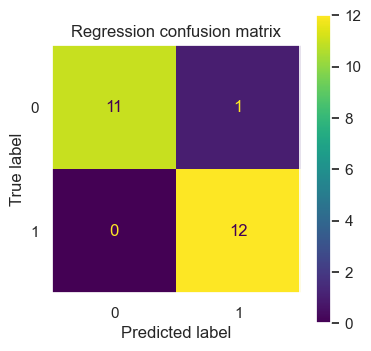

In [46]:
# Confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        test_results["actual"], test_results["regression_predicted"]
    )
)
fig, ax = plt.subplots(figsize = (4, 4))
disp.plot(ax = ax)
disp.ax_.set_title("Regression confusion matrix")
plt.grid(False)
plt.show()

In [47]:
# Summary statistics
regression_incorrect = test_results[
    test_results["regression_predicted"] != test_results["actual"]
]
regression_incorrect.describe()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
count,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
25%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
50%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
75%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
max,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407


In [48]:
# Manual inspection
regression_incorrect.head()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,regression_predicted,tree_predicted,actual
53,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407,True,True,False


In [49]:
regression_incorrect.tail()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,regression_predicted,tree_predicted,actual
53,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407,True,True,False


### Incorrect decision tree predictions

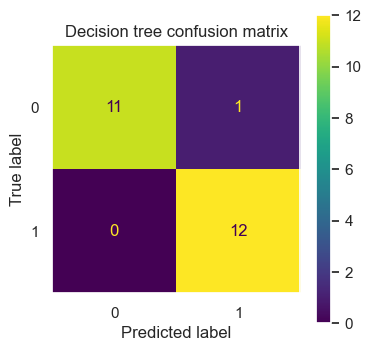

In [50]:
# Confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_results["actual"], test_results["tree_predicted"])
)
fig, ax = plt.subplots(figsize = (4, 4))
disp.plot(ax = ax)
disp.ax_.set_title("Decision tree confusion matrix")
plt.grid(False)
plt.show()

In [51]:
# Summary statistics
tree_incorrect = test_results[test_results["tree_predicted"] != test_results["actual"]]
tree_incorrect.describe()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
count,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
25%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
50%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
75%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
max,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407


In [52]:
# Manual inspection
tree_incorrect.head()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,regression_predicted,tree_predicted,actual
53,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407,True,True,False


In [53]:
tree_incorrect.tail()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length,regression_predicted,tree_predicted,actual
53,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407,True,True,False


### Incorrect predictions from both models simultaneously

In [54]:
# Summary statistics
both_incorrect = test_results[(test_results["regression_predicted"] != test_results["actual"]) & (test_results["tree_predicted"] != test_results["actual"])]
both_incorrect.describe()

,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold,gold_spent,xp,kills,deaths,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
count,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
25%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
50%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
75%,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407
max,0.005317,0.290728,-0.272904,-0.271182,1.0,-0.13603,-0.358831,-0.548759,-0.442748,0.527333,...,-0.055498,-0.371721,-0.645761,-0.021837,-0.081832,-0.495671,-0.045683,-0.604831,-0.048778,0.185407


In [55]:
# Get incorrect rows in original dota df
dota_incorrect = dota.iloc[both_incorrect.index].reset_index(drop = True)
dota_incorrect["predicted"] = both_incorrect.reset_index()["tree_predicted"]
# Get these rows in original unnormalized data (match ID and player slot are unique identifiers)
dota_incorrect_val = dota_incorrect[["match_id", "player_slot", "predicted"]].merge(dota_overall)
dota_incorrect_val

,match_id,player_slot,predicted,team,hero_id,duration,winner,turret_count,inhib_count,aegis,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length
0,45911,0.0,True,blue,107.0,1517.0,False,3.0,4.0,0.0,...,2.0,13.0,998.0,237.0,0.0,8.0,0.0,-0.34,1.0,3.0


In [56]:
# Manual inspection case 1
dota_overall[(dota_overall["match_id"] == 21051)]

,match_id,team,player_slot,hero_id,duration,winner,turret_count,inhib_count,aegis,roshan_kill,...,denies,last_hits,hero_damage,hero_healing,tower_damage,level,polarity_tb,polarity_sia,word_count,avg_word_length


In [57]:
# Manual inspection case 2
dota_overall[(dota_overall["match_id"] == 22058) &
             (dota_overall["team"] == "red")][["match_id", "team", "player_slot", "winner", "gold_spent", "kills", "deaths", "hero_damage"]]

,match_id,team,player_slot,winner,gold_spent,kills,deaths,hero_damage


In [58]:
# Manual inspection case 3
pd.set_option('display.max_columns', 30)
dota_overall[(dota_overall["match_id"] == 39359) &
             (dota_overall["team"] == "blue")][["match_id", "team", "player_slot", "winner", "gold_spent", "kills", "deaths", "hero_damage"]]

,match_id,team,player_slot,winner,gold_spent,kills,deaths,hero_damage


The types of errors (false positives and false negatives) seem pretty balanced (which is what we intended when we used accuracy). In addition, there doesn't seem to be a meaningful pattern that clearly differentiates incorrect predictions at a glance - the statistics and sample observations don't look out of place compared to the original dataset.